In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import plotting

In [5]:
import scipy
from iminuit import cost
from iminuit import Minuit

In [6]:
import hist

In [7]:
plt.style.use(["science", "notebook"])

In [8]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.formatter.limits"] = -5, 4
plt.rcParams["figure.figsize"] = 6, 4
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [9]:
data_path = "/eos/experiment/sndlhc/users/olantwin/advsnd/2024/07/nu12/CCDIS/"

In [10]:
df = pd.read_csv(data_path + "features_CNN_1d_99987.csv")

In [11]:
X = np.load(data_path + "images_1d_99987.npy")

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
y = df["start_z"].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [15]:
def predict(
    X, threshold, threshold_diffs, factor, offset_diffs, offset_even_odd, offset_final
):
    threshold_even = threshold
    threshold_odd = threshold
    threshold_diffs_even = threshold_diffs
    threshold_diffs_odd = threshold_diffs
    X_even = X[:, ::2]
    X_odd = X[:, 1::2]
    even_weight = np.sum(X_even, axis=1)
    odd_weight = np.sum(X_odd, axis=1)
    diffs_even = np.divide(
        (X_even[:, 1:] - X_even[:, :-1]),
        X_even.max(axis=1).reshape(-1, 1),
        where=X_even.max(axis=1).astype(bool).reshape(-1, 1),
    )
    diffs_odd = np.divide(
        (X_odd[:, 1:] - X_odd[:, :-1]),
        X_odd.max(axis=1).reshape(-1, 1),
        where=X_odd.max(axis=1).astype(bool).reshape(-1, 1),
    )
    X_even = np.divide(
        X_even,
        X_even.max(axis=1).reshape(-1, 1),
        where=X_even.max(axis=1).astype(bool).reshape(-1, 1),
    )
    X_odd = np.divide(
        X_odd,
        X_odd.max(axis=1).reshape(-1, 1),
        where=X_odd.max(axis=1).astype(bool).reshape(-1, 1),
    )
    index_even = np.argmax(X_even > threshold_even, axis=1)
    index_odd = np.argmax(X_odd > threshold_odd, axis=1)
    index_diffs_even = np.argmax(diffs_even > threshold_diffs_even, axis=1)
    index_diffs_odd = np.argmax(diffs_odd > threshold_diffs_odd, axis=1)
    values = np.array(
        [
            index_even,
            index_odd + offset_even_odd * index_odd.astype(bool),
            index_diffs_even + offset_diffs * index_diffs_odd.astype(bool),
            index_diffs_odd
            + (offset_even_odd + offset_diffs) * index_diffs_odd.astype(bool),
        ]
    )
    weights = np.array([even_weight, odd_weight, even_weight, odd_weight])
    return (
        factor
        * np.divide(
            np.sum(weights * values, axis=0),
            np.sum(weights * (values != 0), axis=0),
            where=np.sum(values != 0, axis=0).astype(bool),
        )
        + offset_final
    )

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
from skopt import gp_minimize

In [18]:
predict(X[:10000], 10, 0, 1, 0, 0, 0)

array([21.09353492, 11.53856136, 12.        , ..., 52.98615861,
        9.98324022, 31.08662305])

In [19]:
def evaluate_parameters(params):
    y_pred = predict(X_train, *params)
    return mean_squared_error(y_train, y_pred)

In [20]:
gp_res = gp_minimize(
    evaluate_parameters,
    [(0.1, 0.3), (6.0, 10.0), (1.0, 2.0), (12.0, 18.0), (-10.0, 0.0), (-240.0, -220.0)],
    verbose=True,
    n_calls=100,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4316
Function value obtained: 401.6588
Current minimum: 401.6588
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4196
Function value obtained: 71.7173
Current minimum: 71.7173
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4199
Function value obtained: 35.2264
Current minimum: 35.2264
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4204
Function value obtained: 59.0263
Current minimum: 35.2264
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4135
Function value obtained: 594.7981
Current minimum: 35.2264
Iteration No: 6 starte

In [21]:
gp_res.x

[0.25670994489070886,
 9.001139104444807,
 1.504516539398722,
 15.64762324225542,
 -0.49398761750778775,
 -234.63232215407692]

In [22]:
y_pred = predict(X_test, *gp_res.x)

In [24]:
from skopt.plots import plot_convergence

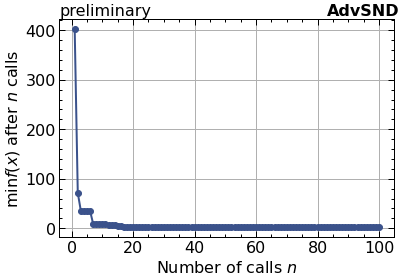

In [25]:
plot_convergence(gp_res)
plt.title("")
plotting.watermark()
plt.savefig("plots/convergence_classic.png")
plt.savefig("plots/convergence_classic.pdf")

In [26]:
h = hist.Hist.new.Regular(100, -5, +5, name=r"𝛥z [cm]").Double()

In [27]:
h.fill(np.squeeze(y_pred) - np.squeeze(y_test))

Hist(Regular(100, -5, 5, name='𝛥z [cm]'), storage=Double()) # Sum: 24804.0 (24997.0 with flow)

In [28]:
entries, edges = h.to_numpy()

In [29]:
def residual_model(x, mu, sigma):
    return scipy.stats.norm.cdf(x, mu, sigma)

In [30]:
m = Minuit(cost.BinnedNLL(entries, edges, residual_model), 0, 25)

In [31]:
res = m.migrad()

In [32]:
res

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4034 (χ²/ndof = 41.2)      │              Nfcn = 100              │
│ EDM = 1.81e-05 (Goal: 0.0002)    │            time = 9.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  -0.106   │   0.007   │            │            │         │         │       │
│ 1 │ sigma │   1.023   │   0.005   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 4.22e-05        0 │
│ sigma │        0 2.11e-05 │
└───────┴───────────────────┘

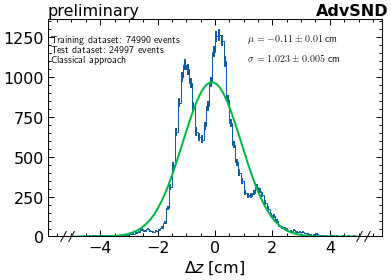

In [33]:
h.plot()
plt.xlabel(r"$\Delta z\;[\mathrm{cm}]$")
plot_range = edges[0], edges[-1]
x = np.linspace(*plot_range, 100)
best_fit = scipy.stats.norm(res.params[0].value, res.params[1].value)
# best_fit = scipy.stats.norm(0.044, 2.83) # TODO take from fit
n_bins = len(entries)
binsize = (plot_range[1] - plot_range[0]) / n_bins
scale = h.sum() / (best_fit.cdf(plot_range[1]) - best_fit.cdf(plot_range[0])) * binsize
plt.plot(x, scale * best_fit.pdf(x))
ax = plt.gca()
# plt.text(0.6, 0.9, r"$\mu = 0.044 $\;cm", transform=ax.transAxes, usetex=True)
plt.text(
    0.6,
    0.9,
    rf"$\mu = {res.params[0].value:.2f} \pm {res.params[0].error:.2f}$\;cm",
    transform=ax.transAxes,
    usetex=True,
)
plt.text(
    0.01,
    0.8,
    f"Training dataset: {len(y_train)} events\n"
    f"Test dataset: {len(y_test)} events\n Classical approach",
    transform=ax.transAxes,
    usetex=True,
)
# plt.text(0.6, 0.81, r"$\sigma = 2.83 $\;cm", transform=ax.transAxes, usetex=True)
plt.text(
    0.6,
    0.81,
    rf"$\sigma = {res.params[1].value:.3f} \pm {res.params[1].error:.3f}$\;cm",
    transform=ax.transAxes,
    usetex=True,
)
plotting.watermark()
plt.savefig(f"plots/h_dz_classic_n{len(y)}.pdf")
plt.savefig(f"plots/h_dz_classic_n{len(y)}.png")